<a href="https://colab.research.google.com/github/Type-1aSN/10-steps-to-become-a-data-scientist/blob/master/Braindecode_Tutorial_Summer_School.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade --no-cache https://github.com/braindecode/braindecode/archive/master.zip
! git clone https://github.com/NeuroTechX/moabb.git
! pip install -r moabb/requirements.txt
! pip install moabb/
! rm -r moabb/

     / 737kB 7.3MB/s
     |████████████████████████████████| 6.6MB 2.9MB/s 
     |████████████████████████████████| 133kB 45.8MB/s 
  Created wheel for Braindecode: filename=Braindecode-0.5-cp36-none-any.whl size=55713 sha256=c185129f308520419f0c6fcf7a97cfc298c945eec9ed68398db7e04eb6a11ca5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5b7mptf/wheels/1b/0e/66/cd3db19ce11758437bc31b93aa1327d7a1123b66333af66a12
Successfully built Braindecode
Cloning into 'moabb'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 2549 (delta 85), reused 69 (delta 36), pack-reused 2411
Receiving objects: 100% (2549/2549), 1.06 MiB | 6.53 MiB/s, done.
Resolving deltas: 100% (1655/1655), done.
     |████████████████████████████████| 51kB 2.3MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 6.5MB 9.9MB/s 
     |████████████████████████████████| 1.2MB 38

In [ ]:
1

1

# Braindecode Tutorial

Main documentation at https://braindecode.org

## Loading and preprocessing the dataset

### Downloading

First, we load the data. In this tutorial, we first download the BCI Competition IV 2a data using [MOABB](https://github.com/NeuroTechX/moabb).


    

In [ ]:
from braindecode.datasets.moabb import MOABBDataset
import mne
mne.set_log_level('error')

subject_id = 3 # a nice subject! :)
MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

### Parsing through MNE into Braindecode

We could use the returned MOABBDataset directly in braindecode. However, to show you how to get your own data into braindecode, we will explicitly parse the downloaded data into [MNE](https://mne.tools/) objects and then create a Braindecode dataset from them.

In [ ]:
from mne.io import RawArray
from mne import create_info
from mne.channels import make_standard_montage
def create_mne_object(run):
    # First pack the signal into an mne RawArray, we need:
    # 1) signal itself
    # 2) channel names
    # 3) channel types
    # 4) sampling frequency

    eeg_data_in_microvolt = run.X
    # These are channel names and types as used in BCI Competition IV dataset 2a
    ch_names = [
        'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2',
        'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz',
        'EOG1', 'EOG2', 'EOG3'
    ]
    ch_types = ['eeg'] * 22 + ['eog'] * 3
    sfreq = run.fs
    
    # MNE expects volt
    eeg_data_in_volt = eeg_data_in_microvolt * 1e-6
    # Create information objet for raw array
    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
    # mne expects channels x timesteps for data,
    # eeg_data is timesteps x channels, so we transpose it
    raw = RawArray(data=eeg_data_in_volt.T, info=info, verbose=False)
    
    # Second, we can add the trials if our data has trials
    # We need:
    # 1) onsets of each trial
    # 2) duration of each trial
    # 3) string-label for each trial
    
    # trial onsets and durations for this dataset
    # trials started 2 seconds after cue
    # and ended 6 seconds after cue
    onset_after_cue = 2
    onsets = ((run.trial-1) / sfreq) + onset_after_cue
    # 4 second trials
    durations = np.full(onsets.shape, 4)
    # Label information for this dataset
    event_desc = {1: 'left_hand', 2: 'right_hand', 3: 'feet', 4: 'tongue'}
    descriptions = [event_desc[y] for y in run.y]
    annots = mne.Annotations(onsets, durations, descriptions)
    raw.set_annotations(annots)
    
    # Optionally we can create the appropriate montage, so data can later be
    # visualized
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)
    return raw

In [ ]:
import os.path
import numpy as np
from scipy.io import loadmat
from braindecode.datasets.base import BaseDataset
from braindecode.datasets.base import BaseConcatDataset

data_folder = os.path.join(mne.get_config('MNE_DATASETS_BNCI_PATH'), 'MNE-bnci-data/database/data-sets/001-2014/')
braindecode_datasets = []
for train_or_eval in ("T", "E"):
    # make an mne 
    filename = os.path.join(data_folder,f'A{subject_id:02d}{train_or_eval}.mat')
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    run_array = data['data']
    # skip baselins runs without trials 
    runs_with_trials = [r for r in run_array if len(r.trial) > 0]
    for i_run, run in enumerate(runs_with_trials):
        raw = create_mne_object(run)
        # now we have an mne object and put it into a braindecode dataset
        base_set = BaseDataset(raw, description=dict(subject=subject_id, session=f'session_{train_or_eval}',
                                         run=f'run_{i_run}'))
        braindecode_datasets.append(base_set)
dataset = BaseConcatDataset(braindecode_datasets)

In [ ]:
dataset.description

,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3
4,3,session_T,run_4
5,3,session_T,run_5
6,3,session_E,run_0
7,3,session_E,run_1
8,3,session_E,run_2
9,3,session_E,run_3


### Preprocessing

Now we apply preprocessing like bandpass filtering to our dataset.
You can either apply functions provided by [mne.Raw](https://mne.tools/stable/generated/mne.io.Raw.html) or apply your own functions, either to the MNE object or the underlying numpy array.

> **Note:** These prepocessings are now directly applied to the loaded data, and not on-the-fly applied as transformations in PyTorch-libraries like [torchvision](https://pytorch.org/docs/stable/torchvision/index.html).


In [ ]:
from braindecode.datautil.preprocess import exponential_moving_standardize
from braindecode.datautil.preprocess import MNEPreproc, NumpyPreproc, preprocess

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    # keep only EEG sensors
    MNEPreproc(fn='pick_types', eeg=True, meg=False, stim=False),
    # convert from volt to microvolt, directly modifying the numpy array
    NumpyPreproc(fn=lambda x: x * 1e6),
    # bandpass filter
    MNEPreproc(fn='filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # exponential moving standardization
    NumpyPreproc(fn=exponential_moving_standardize, factor_new=factor_new,
        init_block_size=init_block_size)
]

# Preprocess the data
preprocess(dataset, preprocessors)

### Cut Compute Windows

Now we cut out compute windows, the inputs for the deep networks during training. In the case of trialwise decoding, we just have to decide if we want to cut out some part before and/or after the trial. For this dataset, in our work, it often was beneficial to also cut out 500 ms before the trial.

In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

### Split dataset into train and valid

We can easily split the dataset using additional info stored in the description attribute, in this case `session` column. We select `session_T` for training and `session_E` for final evaluation later.

In [ ]:
splitted = windows_dataset.split('session')
full_train_set = splitted['session_T']
evaluation_set = splitted['session_E']

Now we split the training part further into training and validation set by run.

In [ ]:
# split by run, first 4 runs training, last 2 for validation
splitted_train = full_train_set.split([[0,1,2,3], [4,5]])

In [ ]:
splitted_train

{'0': <braindecode.datasets.base.BaseConcatDataset at 0x7f4841f40710>,
 '1': <braindecode.datasets.base.BaseConcatDataset at 0x7f4841e4e5c0>}

In [ ]:
train_set = splitted_train['0']
valid_set = splitted_train['1']

In [ ]:
train_set.description

,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3


In [ ]:
valid_set.description

,subject,session,run
0,3,session_T,run_4
1,3,session_T,run_5


Inside an element of the windows dataset, we find:
1. X - the signal of the window as channels x times
2. y - the label of the trial the window was cut out from
3. i - indexing information
  1. i_window_in_trial - Which window within the trial this window is (in this case, as window size is same as trial size, always 0=the first window)
  2. i_start_sample - Which sample in the recording this window starts at
  3. i_stop_sample - Which sample in the recording this window stops at

In [ ]:
X, y, (i_window_in_trial, i_start_sample, i_stop_sample) =  train_set[0]

### Plot window

Let's have a look inside to see what the window looks like.

Text(0.5, 0, 'Timesteps')

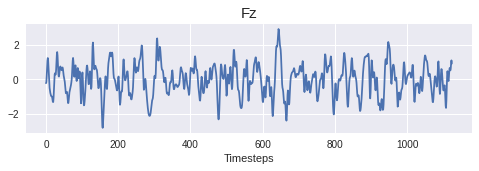

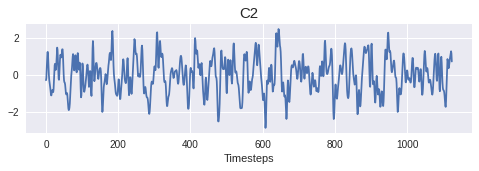

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[0])
plt.title(f"{train_set.datasets[0].windows.ch_names[0]}", fontsize=15)
plt.xlabel("Timesteps")
plt.figure(figsize=(8,2))
plt.style.use('seaborn')
plt.plot(X[10])
plt.title(f"{train_set.datasets[0].windows.ch_names[10]}", fontsize=15)
plt.xlabel("Timesteps")

### Exercise: Largest standard deviation window


Try to find the validation window with the largest standard deviation and plot the sensors as above. To iterate through the windows you can use:

```for X,y,i in valid_set```

## Create model

Now we create the deep learning model! Braindecode comes with some predefined convolutional neural network architectures for
raw time-domain EEG. Here, we use the shallow ConvNet model from
[Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051).
These models are pure [PyTorch](https://pytorch.org) deep learning models, therefore to use your own model, it just has to be a normal PyTorch [nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()
    

## Training

Now we train the network! EEGClassifier is a Braindecode object responsible for managing the training of neural networks. It inherits from skorch.NeuralNetClassifier, so the training logic is the same as in [Skorch](https://skorch.readthedocs.io/en/stable/).

> **Note**: In this tutorial, we use some default parameters that we have found to work well for
motor decoding, however we strongly encourage you to perform your own hyperparameter
optimization using cross validation on your training data.

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 40

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2865        1.6638            0.2396        3.9101  0.0006  0.4797
      2            0.2969        1.2149            0.2396        6.2018  0.0006  0.0909


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3            0.2656        1.0356            0.2604        7.1866  0.0006  0.0930
      4            0.2812        0.9123            0.2604        6.7837  0.0006  0.0919
      5            0.3385        0.8360            0.2500        6.0477  0.0006  0.0896
      6            0.3125        0.7615            0.2604        5.5033  0.0006  0.0883
      7            0.3333        0.7225            0.2604        4.8995  0.0006  0.0907
      8            0.3542        0.6827            0.2604        4.2725  0.0006  0.0898
      9            0.4062        0.5943            0.2500        3.7337  0.0006  0.0898
     10            0.4271        0.5142            0.2708        3.1947  0.0005  0.0879
     11            0.4688        0.5606            0.2812        2.6657  0.0005  0.0884
     12            0.5990        0.4385            0.3125        2.1266  0.0005  0.0890
     13            0.7031        0.4319            0.3333        1.7804  0.0005  0.0898
     14            0.8438       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(69, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

We can recompute the mean accuracy on the validation set just to make sure:


In [ ]:
np.mean(clf.predict(valid_set) == [y for X,y,i in valid_set])

0.6145833333333334

### Exercise: Compute per-class accuracies

### Exercise: Use Deep4Net
Try to use the Deep4Net instead of the ShallowFBCSPNet. 
`from braindecode.models import Deep4Net`

You can also try to change any hyperparameters:

```
Deep4Net(
    in_chans,
    n_classes,
    input_window_samples,
    final_conv_length,
    n_filters_time=25,
    n_filters_spat=25,
    filter_time_length=10,
    pool_time_length=3,
    pool_time_stride=3,
    n_filters_2=50,
    filter_length_2=10,
    n_filters_3=100,
    filter_length_3=10,
    n_filters_4=200,
    filter_length_4=10,
    first_nonlin=<function elu at 0x7f608d347cb0>,
    first_pool_mode='max',
    first_pool_nonlin=<function identity at 0x7f60d36ffa70>,
    later_nonlin=<function elu at 0x7f608d347cb0>,
    later_pool_mode='max',
    later_pool_nonlin=<function identity at 0x7f60d36ffa70>,
    drop_prob=0.5,
    double_time_convs=False,
    split_first_layer=True,
    batch_norm=True,
    batch_norm_alpha=0.1,
    stride_before_pool=False,
)
```

## Plot Results

Now we use the history stored by Skorch throughout training to plot accuracy and loss curves.

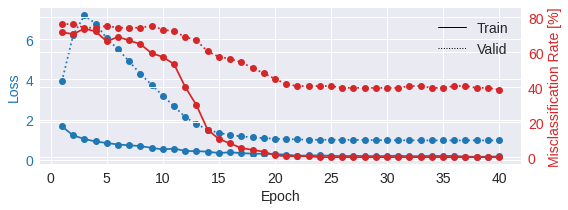

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## Visualization with Amplitude Gradients

We now can try to understand the network a little bit better by computing gradients of the network class predictions on the per-frequency amplitudes of the input.

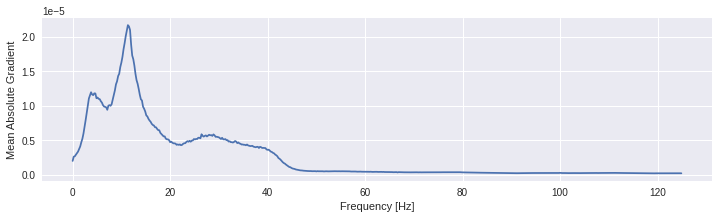

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

We can investigate the alpha band a bit more deeply.

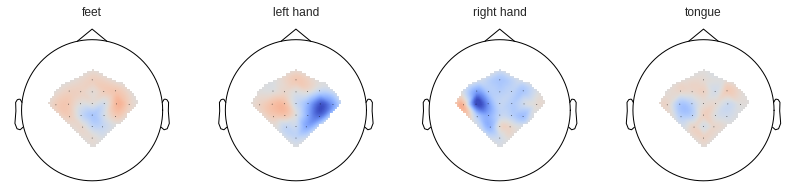

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1


freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

### Exercise: Visualize Another Frequency Range

## Cropped Decoding

Now, we do more data-efficient cropped decoding!

In Braindecode, there are two supported configurations created for training models: trialwise decoding and cropped
decoding. We will explain this visually by comparing trialwise to cropped decoding.

![](https://braindecode.org/_images/trialwise_explanation.png)
![](https://braindecode.org/_images/cropped_explanation.png)


On the left, you see trialwise decoding:

1. A complete trial is pushed through the network.
2. The network produces a prediction.
3. The prediction is compared to the target (label) for that trial to compute the loss.

On the right, you see cropped decoding:

1. Instead of a complete trial, crops are pushed through the network.
2. For computational efficiency, multiple neighbouring crops are pushed through the network simultaneously (these
   neighbouring crops are called compute windows)
3. Therefore, the network produces multiple predictions (one per crop in the window)
4. The individual crop predictions are averaged before computing the loss function

## Create model and compute windowing parameters

We will use the deep4 model this time!

In contrast to trialwise computing, we first have to create the model before we can cut the dataset into windows. This is because we need to know the receptive field of the network to know how large the window stride should be.

We first choose the compute/input window size
that will be fed to the network during training
This has to be larger than the networks receptive field size
and can otherwise be chosen for computational efficiency (see explanations in the beginning of this tutorial). Here we choose 1000 samples, which are 4 seconds.

In [ ]:
input_window_samples = 1000

Now we create the model. To enable it to be used in cropped decoding efficiently, we manually set the length of the final convolution layer to some length that makes the receptive field of the ConvNet smaller than `input_window_samples` (see `final_conv_length=30` in the model definition).

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=2,
)

# Send model to GPU
if cuda:
    model.cuda()
    

And now we transform model with strides to a model that outputs dense prediction, so we can use it to obtain properly predictions for all crops.

In [ ]:
from braindecode.models.util import to_dense_prediction_model, get_output_shape
to_dense_prediction_model(model)

To know the models' receptive field, we calculate the shape of model output for a dummy input.

In [ ]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]

## Cut the data into windows

Now we have to supply an explicit window size and window stride to the `create_windows_from_events` function.

In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True,
)

## Split the dataset

This code is the same as in trialwise decoding.

In [ ]:
splitted = windows_dataset.split('session')
full_train_set = splitted['session_T']
evaluation_set = splitted['session_E']
splitted_train = full_train_set.split([[0,1,2,3], [4,5]])
train_set = splitted_train['0']
valid_set = splitted_train['1']

## Training

In difference to trialwise decoding, we now should supply `cropped=True` to the EEGClassifier, and `CroppedLoss` as the criterion, as well as `criterion__loss_function` as the loss function applied to the meaned predictions.

> **Note**: In this tutorial, we use some default parameters that we have found to work well for
motor decoding, however we strongly encourage you to perform your own hyperparameter
optimization using cross validation on your training data.

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:

# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 40

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3854        3.8146            0.3646       69.2497  0.0100  0.8030


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2            0.2500        1.6961            0.2500       15.4365  0.0100  0.3125
      3            0.2500        1.3722            0.2500        4.9518  0.0099  0.3106
      4            0.3698        1.2634            0.4167        2.7315  0.0099  0.3111
      5            0.3750        1.1962            0.2708        1.7079  0.0097  0.3122
      6            0.4896        1.2015            0.5000        1.4496  0.0096  0.3170
      7            0.5625        1.1118            0.5312        1.1644  0.0094  0.3077
      8            0.6094        1.0753            0.5417        1.1494  0.0092  0.3102
      9            0.5833        1.0495            0.5104        1.2121  0.0090  0.3104
     10            0.5417        1.0588            0.4688        1.2711  0.0087  0.3101
     11            0.6094        1.0233            0.5000        1.2540  0.0085  0.3103
     12            0.5417        1.0090            0.4479        1.2720  0.0082  0.3105
     13            0.5521       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(1, 1), ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
   

### Look at per-window accuracies

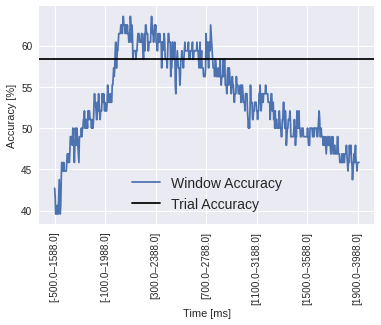

In [ ]:
from braindecode.training.scoring import trial_preds_from_window_preds

predicted_windows = clf.predict_with_window_inds_and_ys(valid_set)
trial_preds = trial_preds_from_window_preds(
    predicted_windows['preds'],
    predicted_windows['i_window_in_trials'],
    predicted_windows['i_window_stops'])
trial_preds = np.array(trial_preds)
window_0_per_trial_mask = np.diff(
    predicted_windows['i_window_in_trials'], prepend=[np.inf]) != 1

trial_ys = predicted_windows['window_ys'][window_0_per_trial_mask]

overall_accuracy = np.mean(np.mean(trial_preds, axis=2).argmax(axis=1) == trial_ys)

acc_per_step = np.mean(trial_preds.argmax(axis=1) == trial_ys[:, None], axis=0)

receptive_field_size = input_window_samples - n_preds_per_input + 1

plt.plot(acc_per_step * 100, label='Window Accuracy')
ax = plt.gca()
xticks = plt.gca().get_xticks()

starts = -500 + xticks * 1000/sfreq
stops = starts + receptive_field_size * 1000/sfreq
labels = [f"[{start}–{stop}]" for start,stop in zip(starts, stops)]
ax.set_xticklabels(labels, rotation=90)
plt.axhline(y=overall_accuracy*100, color='black', label='Trial Accuracy')
plt.ylabel("Accuracy [%]")
plt.xlabel("Time [ms]");
plt.legend(fontsize=14)

### Exercise: Accuracies using the first half and the second half of the predictions

## Visualization with Amplitude Gradients

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

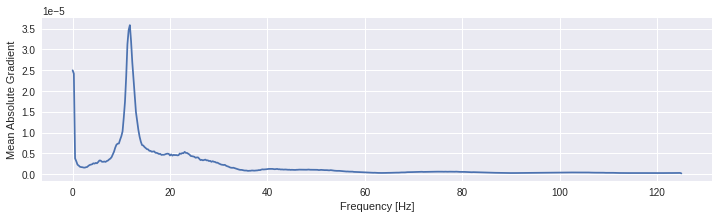

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

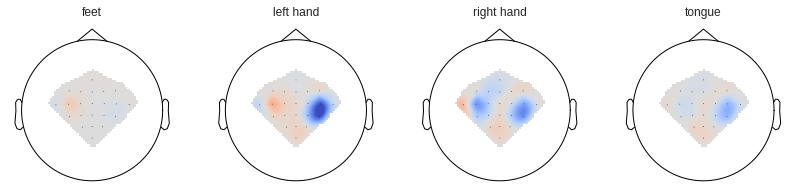

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1


freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

## Use a new model

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]


from torch import nn

class Residual(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return self.module(x) + x

model = nn.Sequential(
    nn.Conv1d(n_chans,50, 11),
    nn.BatchNorm1d(50),
    nn.ELU(),
    Residual(nn.Conv1d(50,50, 11, padding=11//2)),
    nn.ELU(),
    Residual(nn.Conv1d(50,50, 11, padding=11//2)),
    nn.ELU(),
    nn.Conv1d(50,100, 11),
    nn.BatchNorm1d(100),
    nn.ELU(),
    Residual(nn.Conv1d(100,100, 11, padding=(11 + (11 - 1) * (3-1)) // 2, dilation=3)),
    nn.ELU(),
    Residual(nn.Conv1d(100,100, 11, padding=(11 + (11 - 1) * (3-1)) // 2, dilation=3)),
    nn.ELU(),
    nn.Conv1d(100,200, 11, dilation=3),
    nn.BatchNorm1d(200),
    nn.ELU(),
    Residual(nn.Conv1d(200,200,11, padding=(11 + (11 - 1) * (9-1)) // 2, dilation=9)),
    nn.ELU(),
    Residual(nn.Conv1d(200,200,11, padding=(11 + (11 - 1) * (9-1)) // 2, dilation=9)),
    nn.ELU(),
    nn.Conv1d(200,400,11, dilation=27),
    nn.BatchNorm1d(400),
    nn.ELU(),
    Residual(nn.Conv1d(400,400,11, padding=(11 + (11 - 1) * (27-1)) // 2, dilation=27)),
    nn.ELU(),
    Residual(nn.Conv1d(400,400,11, padding=(11 + (11 - 1) * (27-1)) // 2, dilation=27)),
    nn.ELU(),
    nn.Conv1d(400,4, 1),
    nn.LogSoftmax(dim=1),
)
# Send model to GPU
if cuda:
    model.cuda()
    

In [ ]:
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]



import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True,
)


splitted = windows_dataset.split('session')
full_train_set = splitted['session_T']
evaluation_set = splitted['session_E']
splitted_train = full_train_set.split([[0,1,2,3], [4,5]])
train_set = splitted_train['0']
valid_set = splitted_train['1']


from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss

# These values we found good for shallow network:

lr = 5e-4
weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 40

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        2.2769            0.2500        2.8588  0.0005  4.9268


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2            0.4271        1.2845            0.3854        3.3082  0.0005  2.5737
      3            0.2500        1.0066            0.2500        5.6534  0.0005  2.5722
      4            0.3594        0.8530            0.3333        4.2267  0.0005  2.5745
      5            0.3906        0.7469            0.3438        2.5408  0.0005  2.5740
      6            0.6510        0.6999            0.5625        1.2869  0.0005  2.5754
      7            0.5990        0.5879            0.5000        1.5877  0.0005  2.5719
      8            0.4792        0.5416            0.3542        3.0719  0.0005  2.5767
      9            0.5000        0.4506            0.3854        2.1028  0.0004  2.5720
     10            0.8698        0.3746            0.6771        1.0797  0.0004  2.5735
     11            0.7240        0.3401            0.5312        2.3913  0.0004  2.5753
     12            0.7188        0.3153            0.4896        2.4742  0.0004  2.5743
     13            0.7292       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): Conv1d(22, 50, kernel_size=(11,), stride=(1,))
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Residual(
      (module): Conv1d(50, 50, kernel_size=(11,), stride=(1,), padding=(5,))
    )
    (4): ELU(alpha=1.0)
    (5): Residual(
      (module): Conv1d(50, 50, kernel_size=(11,), stride=(1,), padding=(5,))
    )
    (6): ELU(alpha=1.0)
    (7): Conv1d(50, 100, kernel_size=(11,), stride=(1,))
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): Residual(
      (module): Conv1d(100, 100, kernel_size=(11,), stride=(1,), padding=(15,), dilation=(3,))
    )
    (11): ELU(alpha=1.0)
    (12): Residual(
      (module): Conv1d(100, 100, kernel_size=(11,), stride=(1,), padding=(15,), dilation=(3,))
    )
    (13): ELU(alpha=1.0)
    (14): Conv1d(100, 200, kernel

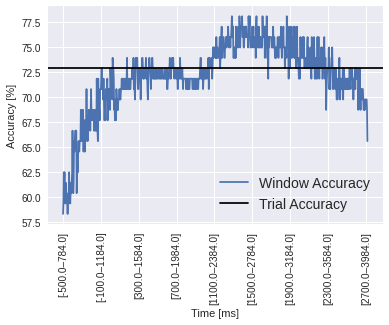

In [ ]:
from braindecode.training.scoring import trial_preds_from_window_preds

predicted_windows = clf.predict_with_window_inds_and_ys(valid_set)
trial_preds = trial_preds_from_window_preds(
    predicted_windows['preds'],
    predicted_windows['i_window_in_trials'],
    predicted_windows['i_window_stops'])
trial_preds = np.array(trial_preds)
window_0_per_trial_mask = np.diff(
    predicted_windows['i_window_in_trials'], prepend=[np.inf]) != 1

trial_ys = predicted_windows['window_ys'][window_0_per_trial_mask]

overall_accuracy = np.mean(np.mean(trial_preds, axis=2).argmax(axis=1) == trial_ys)

acc_per_step = np.mean(trial_preds.argmax(axis=1) == trial_ys[:, None], axis=0)

receptive_field_size = input_window_samples - n_preds_per_input + 1

plt.plot(acc_per_step * 100, label='Window Accuracy')
ax = plt.gca()
xticks = plt.gca().get_xticks()

starts = -500 + xticks * 1000/sfreq
stops = starts + receptive_field_size * 1000/sfreq
labels = [f"[{start}–{stop}]" for start,stop in zip(starts, stops)]
ax.set_xticklabels(labels, rotation=90)
plt.axhline(y=overall_accuracy*100, color='black', label='Trial Accuracy')
plt.ylabel("Accuracy [%]")
plt.xlabel("Time [ms]");
plt.legend(fontsize=14)

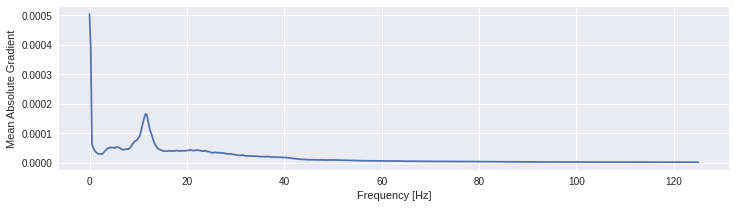

In [ ]:
from braindecode.visualization.gradients import compute_amplitude_gradients

amp_grads_per_filter = compute_amplitude_gradients(model, train_set, batch_size=64)

plt.figure(figsize=(12,3))
plt.plot(np.fft.rfftfreq(train_set[0][0].shape[1], 1/250.0), np.mean(np.abs(amp_grads_per_filter), axis=(0, 1,2)));
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean Absolute Gradient');

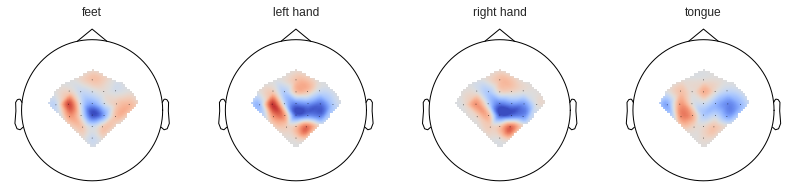

In [ ]:
sfreq = train_set.datasets[0].windows.info['sfreq']
freqs = np.fft.rfftfreq(train_set[0][0].shape[1], d=1.0/sfreq)
start_freq = 7
stop_freq = 14
i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(np.mean(amp_grads_per_filter, axis=1)[:,:,i_start:i_stop], axis=2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

class_to_id = windows_dataset.datasets[0].windows.event_id

fig, axes = plt.subplots(1, len(class_to_id), figsize=(14,4))
for class_name, i_class in class_to_id.items():
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[i_class], train_set.datasets[0].windows.info,
             vmin=-max_abs_val, vmax=max_abs_val, contours=0,
            cmap=cm.coolwarm, show=False, extrapolate='local',
                        axes=ax);
    ax.set_title(class_name.replace('_', ' '))

### Exercises: Develop your own pipeline

* Try other preprocessings
* Try other trial boundaries
* Try other hyperparameters for model
* Try your own pytorch model

In the end: evaluate on final evaluation set and let's compare!

See more on https://braindecode.org